In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from networkx.convert_matrix import to_pandas_edgelist
from ipywidgets import IntProgress
from IPython.display import display
import time
from subsampling import get_samples_from_relation_with_chunks
import os


In [131]:
#CONSTANTS NEEDED FOR THE NOTEBOOK

DATA_ROOT = '../data/' #where usersdata.csv and relations.csv are located
GRAPH_ROOT = '../graphs/' #where we store all informations about the graphs
NODES_PATH = GRAPH_ROOT + 'nodes_rel_'
GRAPHS_PATH = GRAPH_ROOT + 'full_rel_'
SUBGRAPHS_PATH = GRAPH_ROOT + 'ratio_01_rel_'
GEXF = '.gexf'
CSV = '.csv'

usersdata_initial = pd.read_csv(DATA_ROOT+'usersdata.csv', delimiter = '\t', names = ['userId', 'sex', 'timePassedValidation', 'ageGroup', 'label'])

This Notebook has been run with an Intel Core i7-8750H CPU with 16Go of RAM

## Sampling

Due to memory limitations, networkx can't create graphs from relations 3 to 6. So we had to sample those relations to create "subgraphs" of those relations. We followed a traversal method using breadth first search principle : starting from a vertex and iteratively looking at its neighbors (then the neighbors of the neighbors) until we reach a certain amount of users. In order to retrieve all the features using networkx we stopped the sampling algorithm when 10% of the 5.6M users are in the subgraph. 

In [97]:
'''
set computation to True the first time we compute this feature. If the corresponding column exist in for every relation, the set it to False.
Then we only load the nodes with the triangles count values so that we can merge it in the usersdata dataframe directly.
'''
COMPUTATION = False

ratio = 0.1
for i in range(1,8):
    print('for relation {}...'.format(i))
    if i in [3,4,5,6]:
        graph_path = SUBGRAPHS_PATH + str(i) + GEXF
    else:
        graph_path = GRAPHS_PATH + str(i) + GEXF   
    
    output_nodes = NODES_PATH + str(i) + CSV
    
    existence = os.path.isfile(output_nodes) and  os.path.isfile(graph_path)
    if existence and not(COMPUTATION):
        print('the graph already exists and no recomputation is requested')
        continue
    else :
        if i in [3,4,5,6]:
            nodes, edgelist = get_samples_from_relation_with_chunks(DATA_ROOT+'relation_'+str(i)+'.csv', num_of_nodes = int(np.floor(ratio*len(usersdata_initial))), chunksize = 500000)
        else:
            relation_df = pd.read_csv(DATA_ROOT+'relation_'+str(i)+ CSV, delimiter = ',').groupby(['src','dst']).agg({'time_ms':'sum'}).reset_index() #removing duplicates
            print('relation retrieved successfully')
            rel_users = list(set(relation_df['src'].unique()).union(set(relation_df['dst'].unique())))
            nodes = usersdata_initial[usersdata_initial['userId'].isin(rel_users)]
            
            edges = relation_df[['src', 'dst']]
            nodes.reset_index(level=0, inplace=True)
            nodes = nodes.drop(columns={'index'})
            nodes.reset_index(level=0, inplace=True)
            nodes = nodes.rename(columns = {'index':'node_idx'})

            uid2idx = nodes[['node_idx', 'userId']]
            uid2idx = uid2idx.set_index('userId')

            edges_renumbered = edges.join(uid2idx, on = 'src').join(uid2idx, on = 'dst', rsuffix = '_dst')

            edgelist = edges_renumbered[['node_idx','node_idx_dst']]
        
        nodes.to_csv(output_nodes)
        edgelist.to_csv(GRAPH_ROOT + 'edgelist_01_rel_'+str(i)+ CSV)
        print("edgelist created, creation of the graph...")
        graph = nx.from_pandas_edgelist(edgelist, source = 'node_idx', target = 'node_idx_dst', create_using=nx.DiGraph())
        attributes = nodes[['node_idx','ageGroup', 'timePassedValidation', 'label']].set_index('node_idx')
        attributes.rename(columns = {'label':'spammer'}, inplace = True)
        node_props = attributes.to_dict() #, 'timePassedValidation', 'ageGroup'
        for key in node_props:
            nx.set_node_attributes(graph, node_props[key], key)
        nx.write_gexf(graph, graph_path)
        print('graph successfully saved')

for relation 1...
the graph already exists and no recomputation is requested
for relation 2...
the graph already exists and no recomputation is requested
for relation 3...
the graph already exists and no recomputation is requested
for relation 4...
the graph already exists and no recomputation is requested
for relation 5...
the graph already exists and no recomputation is requested
for relation 6...
the graph already exists and no recomputation is requested
for relation 7...
the graph already exists and no recomputation is requested


## Exploration

#### Degree Distribution

We want to make a primary analysis of the graphs by looking at their degree distribution and the differences between the relations.

In [102]:
'''
set computation to True the first time we compute this feature. If the corresponding column exist in for every relation, the set it to False.
Then we only load the nodes with the triangles count values so that we can merge it in the usersdata dataframe directly.
'''
COMPUTATION = False

xs = []
ys = []

for i in range(1,8):
    print('for relation {}...'.format(i))
    
    graph_input = GRAPHS_PATH + str(i) + GEXF
    
    if i in [3,4,5,6]:
        graph_input = SUBGRAPHS_PATH + str(i) + GEXF

    nodes_input = NODES_PATH + str(i) + CSV
    nodes_output = nodes_input
        
    print('loading the nodes...')
    nodes = pd.read_csv(nodes_input).drop(columns = {'Unnamed: 0'}) 

    if COMPUTATION:
        print('loading the graph...')
        if not(os.path.isfile(graph_path)):
            print('the graph does not exist for the relation {}'.fomat(i))
            continue
        graph = nx.read_gexf(graph_input)
        print('computing the degrees...')
        degrees = nx.degree(graph)
        print('computing in_degrees...')
        in_deg = graph.in_degree()
        print('computing out_degrees...')
        out_deg = graph.out_degree()
        nodes['in_degree_'+str(i)] = nodes.apply(lambda x : in_deg[str(x['node_idx'])], axis = 1)
        nodes['out_degree_'+str(i)] = nodes.apply(lambda x : out_deg[str(x['node_idx'])], axis = 1)
        nodes['degree_'+str(i)] = nodes.apply(lambda x : degrees[str(x['node_idx'])], axis = 1)
        nodes.to_csv(nodes_output)
    
    vc = nodes['degree_'+str(i)].value_counts().sort_index()
    ys.append(vc.values / np.sum(vc.values))
    xs.append(vc.index)
    print('Done!')

for relation 1...
loading the nodes...
loading the graph...
computing the degrees...
computing in_degrees...
computing out_degrees...
Done!


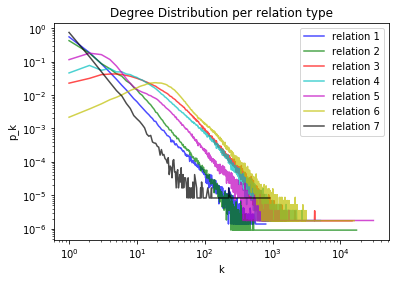

In [9]:
colors = ['b','g','r','c','m','y','k']
label = 'relation '
for i in range(1,8):
    plt.loglog(xs[i-1], ys[i-1], color = colors[i-1],alpha=0.7, label = label+str(i))
plt.title('Degree Distribution per relation type')
plt.xlabel('k')
plt.ylabel('p_k')
plt.legend()
plt.show()

We can observe that the curve of the relations {1,2,7} are linear in a log_log scale meaning the $log(p_k)\propto -\alpha log(k)$. So those degree distributions follow power law distributions meaning that those graphs are scale-free network. 
The degree distributions of the relations {3,4,5,6} are heavy tail, meaning that most of the nodes have low degrees and hubs exists, such as the other relations. However the curves are not linear in log log scale so they are not following power law distributions. Also theye are not random networks but it seems they are in sublinear regime following a stretched exponential distribution limiting the size and the number of the hubs.
$$p_k\ =\ k^{-\alpha}\exp\left(-\frac{2\mu(\alpha)}{\langle k\rangle (1-\alpha)}k^{\left(1-\alpha\right)}\right)$$

So the current hypothesis is that the sampling algorithm did modify the global architecture of the relations {3,4,5,6}. In order to verify this hypothesis we will retrieve the degree distributions of the full graphs related to those relations.

NB : we didn't manage to compute the algorithm for the relation 6 so we will base the analysis on the relations {3,4,5}.

In [4]:
'''
due to memory limitations the cell cannot calculate distributions for all relationships at once. So thanks to the memorization
of the distributions we can restart the kernel and restart the cell which will continue to calculate the distributions from the 
last unsaved relation.
'''
vcs = []
for i in range(3,6):
    output_path = DATA_ROOT+'degrees_rel_'+str(i)+CSV
    print('for relation {}'.format(i))
    if os.path.isfile(output_path):
        print('retrieving existing degrees dataframe')
        degrees = pd.read_csv(output_path).drop(columns={'Unnamed: 0'})
    else:
        if i == 6 :
            #the relation 6 is too big for the process even with a different approach so we skip it
            '''
            chunks = pd.read_csv(file,iterator=True,delimiter=',', chunksize=500000)
            list_in = []
            list_out = []
            for chunk in chunks : 
                in_d = chunk.dst.value_counts().to_frame().rename(columns = {'dst':'in_degree'}).reset_index()
                out_d = chunk.src.value_counts().to_frame().rename(columns = {'src':'out_degree'}).reset_index()
                list_in.append(in_d)
                list_out.append(out_d)
            out_d = pd.concat(list_out).groupby('index').agg({'out_degree':'sum'})
            in_d = pd.concat(list_in).groupby('index').agg({'in_degree':'sum'})
            out_d['in_degree'] = out_d['out_degree'].astype(float)
            in_d['in_degree'] = in_d['in_degree'].astype(float)
            '''
            continue
        else:
            print('retrieving relation dataframe...')
            file = DATA_ROOT+'relation_' + str(i)+'.csv'
            chunks = pd.read_csv(file,iterator=True,delimiter=',', chunksize=500000)
            relation_df = pd.concat([chunk for chunk in chunks])
            print('computing degrees...')
            in_d = relation_df['dst'].value_counts().to_frame().rename(columns = {'dst':'in_degree'})
            out_d = relation_df['src'].value_counts().to_frame().rename(columns = {'src':'out_degree'})
        degrees = usersdata_initial.join(in_d, on = 'userId', how = 'left').fillna(0).join(out_d, on = 'userId', how = 'left').fillna(0)
        degrees['degree'] = degrees.apply(lambda x : x['in_degree'] + x['out_degree'], axis = 1)
        degrees = degrees[degrees['degree'] != 0.]
        degrees.to_csv(DATA_ROOT+'degrees_rel_'+str(i)+CSV)
    vcs.append(degrees.degree.value_counts().sort_index())

for relation 3
retrieving existing degrees dataframe
for relation 4
retrieving existing degrees dataframe
for relation 5
retrieving existing degrees dataframe


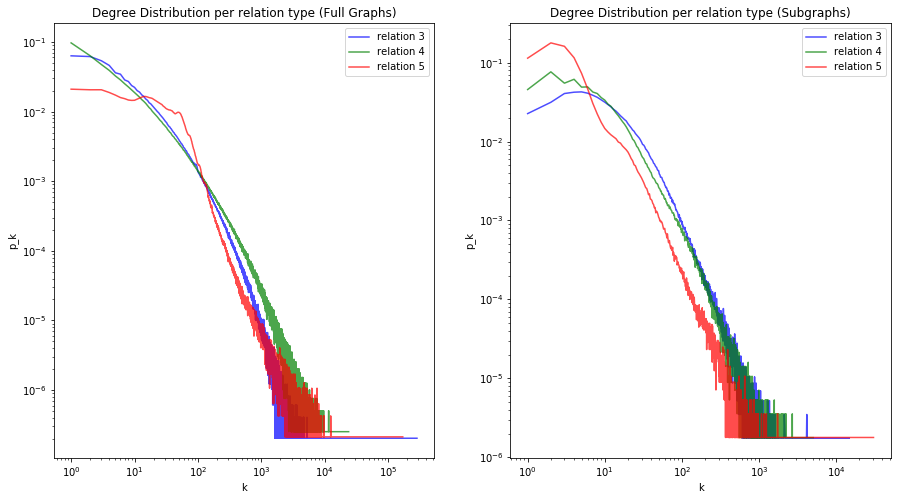

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,8))


colors = ['b','g','r']
for i in range(len(vcs)):
    vc = vcs[i]
    ax1.loglog(vc.index, vc.values / np.sum(vc.values), label = 'relation '+str(i+3), color = colors[i], alpha = 0.7)
ax1.set_title("Degree Distribution per relation type (Full Graphs)")
ax1.set_xlabel('k')
ax1.set_ylabel('p_k')
ax1.legend()

for i in range(2,5):
    ax2.loglog(xs[i], ys[i], label = 'relation '+str(i+1), color = colors[i-2], alpha = 0.7)
ax2.set_title("Degree Distribution per relation type (Subgraphs)")
ax2.set_xlabel('k')
ax2.set_ylabel('p_k')
ax2.legend()
plt.show()

So we observe that the original graphs are also in a sublinear regime and the sampling modifies the $\alpha$ and $\mu$ parameters of the stretched exponential distributions.

#### Spammers vs Non Spammers

As the spammers and non spammers may have different behavior in the relations (the spammers tend to 'contact' other users who won't respond to the spammers). So we expect that the in_degree and out_degree distributions shall differ between the spammers and the non spammers.
To compare those distributions, we will use the subgraphs for relations {3,4,5,6}.

First, let's compare the degree distributions by users label

In [33]:
def plt_sp_nsp(ax, rel):
    
    nodes_input = 'graphs/nodes_rel_' + rel + CSV
    nodes = pd.read_csv(nodes_input).drop(columns = {'Unnamed: 0'}) 

    spammers = nodes[nodes['label'] == 1]
    non_spammers = nodes[nodes['label'] == 0]

    vc_spammers = spammers['degree_' + rel].value_counts().sort_index()
    vc_non_spammers = non_spammers['degree_' + rel].value_counts().sort_index()

    y1 = vc_spammers.values / np.sum(vc_spammers.values)
    y2 = vc_non_spammers.values / np.sum(vc_non_spammers.values)

    x1 = vc_spammers.index
    x2 = vc_non_spammers.index
    colors = ['r','g']
    labels = ['spammers', 'non spammers']
    ax.loglog(x1, y1, color = colors[0], alpha= 0.7, label = labels[0])
    ax.loglog(x2, y2, color = colors[1], alpha = 0.7, label = labels[1])
    ax.set_title("Degree Distribution for relation " + rel +" by users label")
    ax.set_xlabel('k')
    ax.set_ylabel('p_k')
    ax.legend()

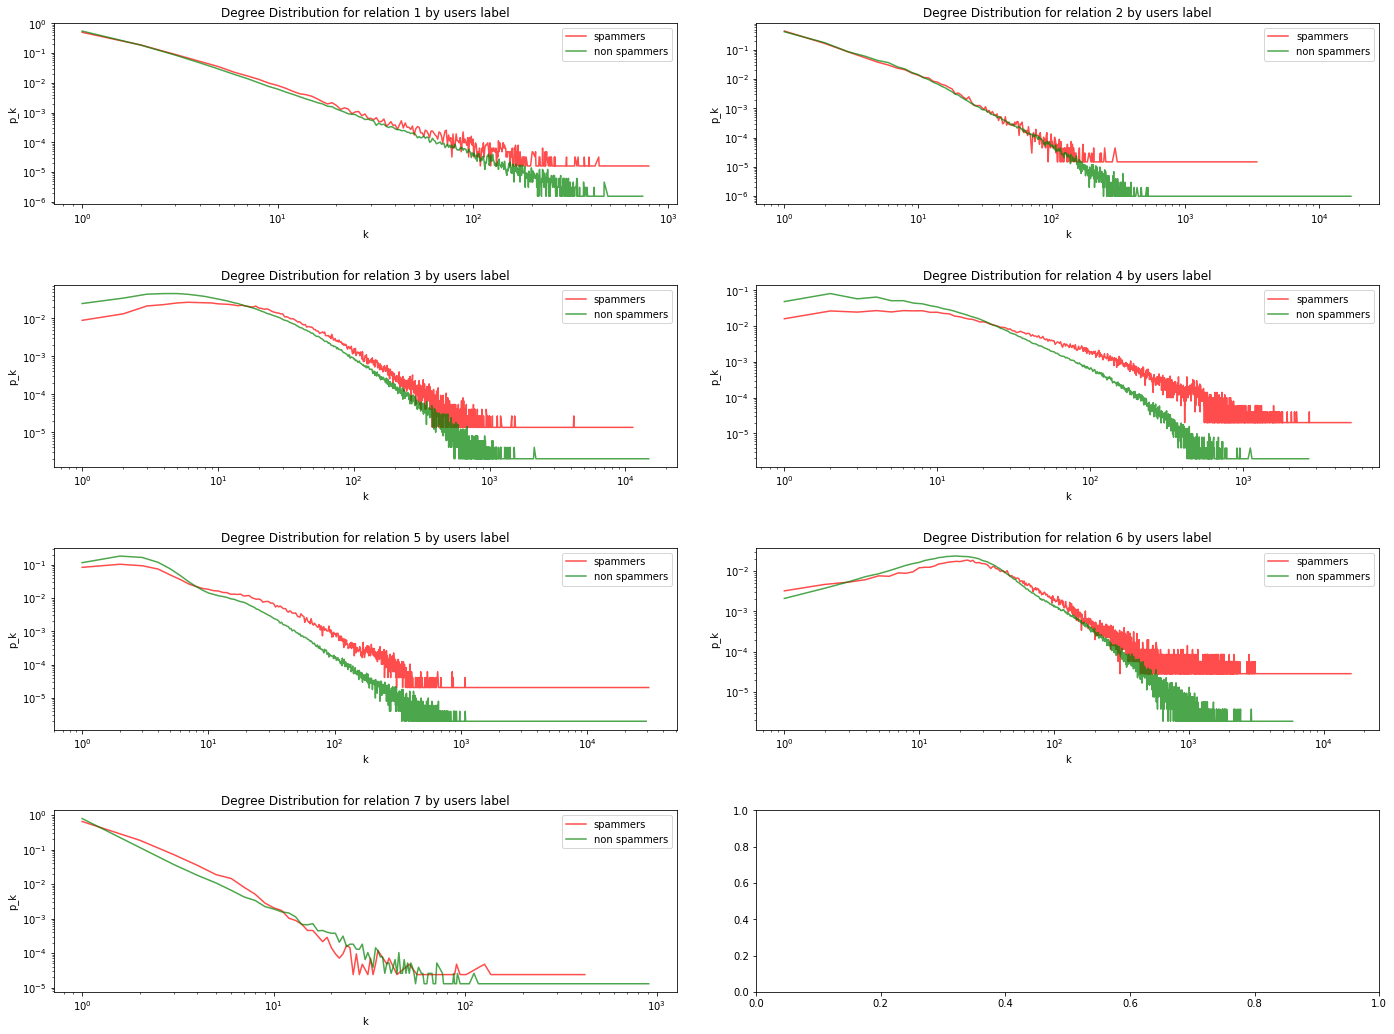

In [36]:
fig, axs = plt.subplots(4, 2, figsize = (20,15))

for i in range(0,7):
    plt_sp_nsp(axs[i//2, i%2], str(i+1))

fig.tight_layout(pad=3.0)
plt.show()

For relations {3,4,5,6,7}, we can globally see that low degree nodes are less numerous in spammers than in non-spammers, whereas high degree nodes are more numerous in spammers than in non-spammers. Indeed, this shows that spammers are more likely to connect to a large number of users compared to non-spammers.

On the other hand, the distributions are very similar between spammers and non-spammers for relations 1 and 2. So we want, for those relations, to push the analysis further to see if we can see differences in the distributions for those two relations.

In [37]:
def plt_inout_sp_nsp(axs, rel):
    nodes = pd.read_csv('graphs/nodes_rel_'+rel+'.csv')
    spammers = nodes[nodes['label'] == 1]
    non_spammers = nodes[nodes['label'] == 0]
    vc_in_sp = spammers['in_degree_' + rel].value_counts().sort_index()
    vc_in_nsp = non_spammers['in_degree_' + rel].value_counts().sort_index()
    vc_out_sp = spammers['out_degree_' + rel].value_counts().sort_index()
    vc_out_nsp = non_spammers['out_degree_' + rel].value_counts().sort_index()
    x1 = vc_in_sp.index
    x2 = vc_in_nsp.index
    x3 = vc_out_sp.index
    x4 = vc_out_nsp.index

    y1 = vc_in_sp.values / np.sum(vc_in_sp.values)
    y2 = vc_in_nsp.values / np.sum(vc_in_nsp.values)
    y3 = vc_out_sp.values / np.sum(vc_out_sp.values)
    y4 = vc_out_nsp.values / np.sum(vc_out_nsp.values)
    
    colors = ['r','g', 'darkorange', 'olive']
    labels = ['in_degrees spammers', 'in_degrees non spammers', 'out_degrees spammers', 'out_degrees non spammers']
    axs[0].loglog(x1, y1, color = colors[0], alpha= 0.7, label = labels[0])
    axs[0].loglog(x2, y2, color = colors[1], alpha = 0.7, label = labels[1])
    axs[0].set_title("In_Degree Distribution for relation " + rel +" by users label")
    axs[0].set_xlabel('k')
    axs[0].set_ylabel('p_k')
    axs[0].legend()
    axs[1].loglog(x3, y3, color = colors[2], alpha= 0.7, label = labels[2])
    axs[1].loglog(x4, y4, color = colors[3], alpha = 0.7, label = labels[3])
    axs[1].set_title("Out_Degree Distribution for relation " + rel +" by users label")
    axs[1].set_xlabel('k')
    axs[1].set_ylabel('p_k')
    axs[1].legend()

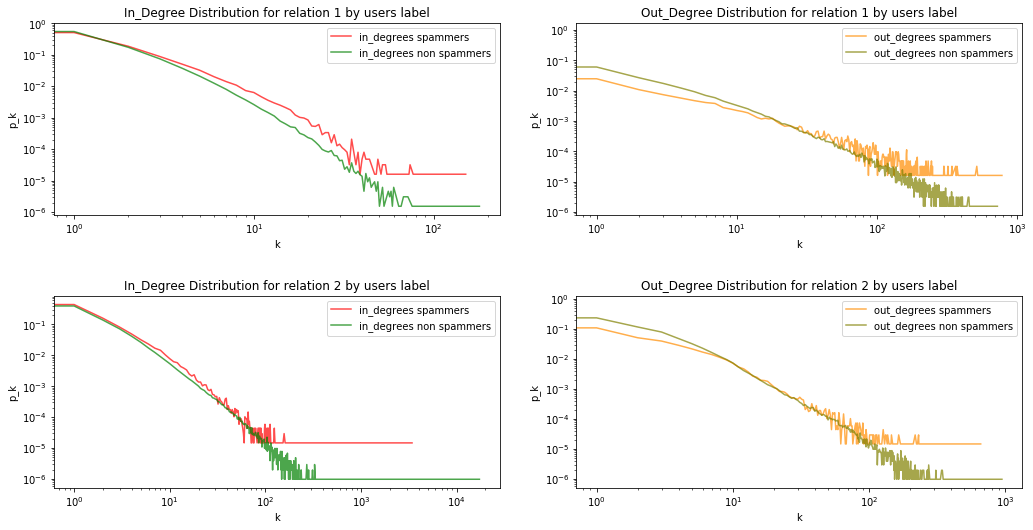

In [39]:
fig, axs = plt.subplots(2, 2, figsize = (15,8))

for i in range(0,2):
    plt_inout_sp_nsp(axs[i], str(i+1))

    
fig.tight_layout(pad=3.0)
plt.show()

Indeed, by observing the in and out degree distribution seperately we can observe that differences exist. According to the out degree distributions, spammers tend to connect to more user than non spammers. However the in_degree distributions are relatively similar between spammers and non spammers despite the fact that for spammers, high degree nodes are more numerous than for non spammers in relation 1. So in this relations, users tend to connect more to spammers than to non spammers. As a consequence, the behavior of a spammer can be close to a non spammer.

This motivates us to look further in the properties of the graphs. Indeed, if the behavior of spammer node is similar to a non spammer node, we can look at the neighbors of a node to see if the neighbors of a spammer node and the ones of a non spammer node have different behaviors

#### Clustering Coefficient

The feature that can inform us about how the neighbors of a node are connected to each others is the clustering coefficient, which thus would give us some informations about the neighbors of spammers and non spammers

In [106]:
'''
set computation to True the first time we compute this feature. If the corresponding column exist in nodes dataframe for every relation, 
then set it to False.
'''
COMPUTATION = False

spammers_ac = []
non_spammers_ac = []

for i in range(1,8):
    print('for relation {}...'.format(i))
    
    graph_input = GRAPHS_PATH + str(i) + GEXF
    
    if i in [3,4,5,6]:
        graph_input = SUBGRAPHS_PATH + str(i) + GEXF

    nodes_input = NODES_PATH + str(i) + CSV
    nodes_output = nodes_input
        
    print('loading the nodes...'
    nodes = pd.read_csv(nodes_input).drop(columns = {'Unnamed: 0'}) 

    if COMPUTATION:
        print('loading the graph...')
        if not(os.path.isfile(graph_path)):
            print('the graph does not exist for the relation {}'.fomat(i))
            continue
        graph = nx.read_gexf(graph_input)
        print('computing the clustering coefficient...')
        clustering = nx.clustering(graph)
        nodes['CC_'+str(i)] = nodes.apply(lambda x : clustering[str(x['node_idx'])], axis = 1)
        nodes.to_csv(nodes_output)
    
    print('computing average clustering of the graph by users label...')
    spammers_ac.append(np.mean(nodes[nodes['label'] == 1]['CC_'+str(i)].values))
    non_spammers_ac.append(np.mean(nodes[nodes['label'] == 0]['CC_'+str(i)].values))
                           
    print('Done!')

for relation 1...
loading the nodes...
computing average clustering of the graph by users label...
Done!
for relation 2...
loading the nodes...
computing average clustering of the graph by users label...
Done!
for relation 3...
loading the nodes...
computing average clustering of the graph by users label...
Done!
for relation 4...
loading the nodes...
computing average clustering of the graph by users label...
Done!
for relation 5...
loading the nodes...
computing average clustering of the graph by users label...
Done!
for relation 6...
loading the nodes...
computing average clustering of the graph by users label...
Done!
for relation 7...
loading the nodes...
computing average clustering of the graph by users label...
Done!


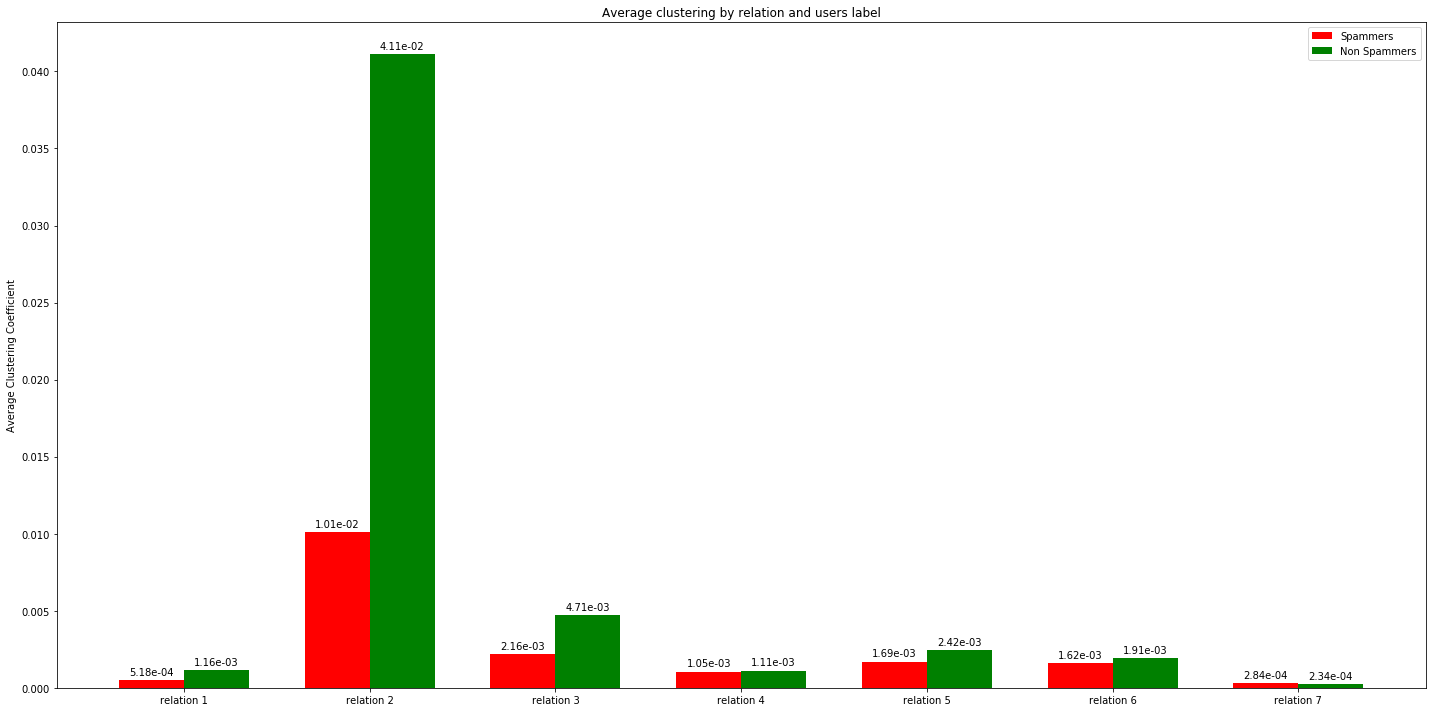

In [49]:
#inspired from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

labels = ['relation 1', 'relation 2', 'relation 3', 'relation 4', 'relation 5', 'relation 6', 'relation 7']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (20,10))
rects1 = ax.bar(x - width/2, spammers_ac, width, label='Spammers', color = 'r')
rects2 = ax.bar(x + width/2, non_spammers_ac, width, label='Non Spammers', color = 'g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Clustering Coefficient')
ax.set_title('Average clustering by relation and users label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("%.2e"%height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Despite the relation 7, we can globally observe that the average clustering coefficient is higher for non spammers than for spammers. It means that the neighbors of a spammer are less connected to each other than the ones of a non spammer user. It can be explained by the fact that a spammer would tend to connect to users who will not necessarily inform other users of his presence in the network. As a consequence the spammer will target users that connected to each others.

## Extraction

### Retrieving the users data

In [50]:
usersdata_initial = pd.read_csv(DATA_ROOT+'usersdata.csv', delimiter = '\t', names = ['userId', 'sex', 'timePassedValidation', 'ageGroup', 'label'])

In [52]:
usersdata = usersdata_initial.copy() #we will store all features in this dataframe

### Degrees, In_Degrees, Out_Degrees and Clustering Coefficient

In [53]:
for i in range(1,8):
    print('for relation {}...'.format(i))    
    output_nodes = NODES_PATH + str(i) + CSV
    
    print('retrieving the nodes attributes')
    nodes = pd.read_csv(output_nodes).drop(columns = {'Unnamed: 0'})
    
    features = ['degree_'+str(i), 'in_degree_'+str(i), 'out_degree_'+str(i), 'CC_'+str(i)]
    
    for f in features:
        print('merge ' + f + ' attributes...')
        #we merge the nodes attributes to the usersdata dataframe by a left outer join : we keep the NAN values for now
        usersdata = usersdata.merge(nodes[['userId', f]], left_on = 'userId', right_on = 'userId', how = 'left') 
    print('Done!')

for relation 1...
retrieving the nodes attributes
merge degree_1 attributes...
merge in_degree_1 attributes...
merge out_degree_1 attributes...
merge CC_1 attributes...
Done!
for relation 2...
retrieving the nodes attributes
merge degree_2 attributes...
merge in_degree_2 attributes...
merge out_degree_2 attributes...
merge CC_2 attributes...
Done!
for relation 3...
retrieving the nodes attributes
merge degree_3 attributes...
merge in_degree_3 attributes...
merge out_degree_3 attributes...
merge CC_3 attributes...
Done!
for relation 4...
retrieving the nodes attributes
merge degree_4 attributes...
merge in_degree_4 attributes...
merge out_degree_4 attributes...
merge CC_4 attributes...
Done!
for relation 5...
retrieving the nodes attributes
merge degree_5 attributes...
merge in_degree_5 attributes...
merge out_degree_5 attributes...
merge CC_5 attributes...
Done!
for relation 6...
retrieving the nodes attributes
merge degree_6 attributes...
merge in_degree_6 attributes...
merge out_degr

In [54]:
checkp_path = DATA_ROOT+'usersdata_with_fd_cc_01_nan.csv'
usersdata.to_csv(checkp_path)#we will store all features in this dataframe

The following cell is runned if we want to get the previous result after starting the kernel

In [130]:
#checkpoint cell
checkp_path = DATA_ROOT+'usersdata_with_fd_cc_01_nan.csv'
usersdata = pd.read_csv(checkp_path)#we will store all features in this dataframe

NameError: name 'DATA_ROOT' is not defined

### Pagerank

In [110]:
'''
set computation to True the first time we compute this feature. If the corresponding column exist in nodes dataframe for every relation, 
then set it to False.
'''
COMPUTATION = False
ratio = 0.1
for i in range(1,8):
    print('for relation {}...'.format(i))
    if i in [3,4,5,6]:
        graph_path = SUBGRAPHS_PATH + str(i) + GEXF
    else:
        graph_path = GRAPHS_PATH + str(i) + GEXF   
    
    output_nodes = NODES_PATH + str(i) + CSV
    
    print('retrieve existing nodes...')
    nodes = pd.read_csv(output_nodes).drop(columns = {'Unnamed: 0'})
    
    if COMPUTATION :
        print('loading graph...')
        if not(os.path.isfile(graph_path)):
            print('the graph does not exist for the relation {}'.fomat(i))
            continue
        graph = nx.read_gexf(graph_path)
        print("computing the pagerank of the relation {}".format(i))
        pr = nx.pagerank(graph)
        nodes['pagerank_' + str(i)] = nodes.apply(lambda x: float(pr[str(x['node_idx'])]), axis = 1)
        nodes.to_csv(output_nodes)
        
    #we merge the nodes attributes to the usersdata dataframe by a left outer join : we keep the NAN values for now
    usersdata = usersdata.merge(nodes[['userId', 'pagerank_'+str(i)]], left_on = 'userId', right_on = 'userId', how = 'left')
    print("Successfull process for relation {}".format(i))

for relation 1...
retrieve existing nodes...
Successfull process for relation 1
for relation 2...
retrieve existing nodes...
Successfull process for relation 2
for relation 3...
retrieve existing nodes...
Successfull process for relation 3
for relation 4...
retrieve existing nodes...
Successfull process for relation 4
for relation 5...
retrieve existing nodes...
Successfull process for relation 5
for relation 6...
retrieve existing nodes...
Successfull process for relation 6
for relation 7...
retrieve existing nodes...
Successfull process for relation 7


Save the results at this state

In [69]:
final_output_pr = DATA_ROOT+'usersdata_with_pr_01_nan.csv'
usersdata.to_csv(final_output_pr)

The following cell is runned if we want to get the previous result after starting the kernel

In [74]:
#checkpoint cell
usersdata = pd.read_csv(DATA_ROOT+'usersdata_with_pr_01_nan.csv')

### Triangles Count

In [112]:
'''
set computation to True the first time we compute this feature. If the corresponding column exist in for every relation, the set it to False.
'''
COMPUTATION = False 

for i in range(1,8):
    print('for relation {}...'.format(i))
    if i in [3,4,5,6]:
        graph_path = GRAPH_ROOT + 'ratio_01_rel_' + str(i) + GEXF
    else:
        graph_path = GRAPH_ROOT + 'full_rel_' + str(i) + GEXF   
    
    output_nodes = NODES_PATH + str(i) + CSV
    
    nodes = pd.read_csv(output_nodes).drop(columns = {'Unnamed: 0'})
    
    if COMPUTATION:
        print('loading the graph...')
        if not(os.path.isfile(graph_path)):
            print('the graph does not exist for the relation {}'.fomat(i))
            continue
        graph = nx.read_gexf(graph_path)
        print('computing triangles count...')
        tr = nx.triangles(graph.to_undirected())
        nodes['triangles_count_' + str(i)] = nodes.apply(lambda x : tr[str(x['node_idx'])], axis = 1)
        nodes.to_csv(output_nodes)
    
    #we merge the nodes attributes to the usersdata dataframe by a left outer join : we keep the NAN values for now
    usersdata = usersdata.merge(nodes[['userId', 'triangles_count_'+str(i)]], left_on = 'userId', right_on = 'userId', how = 'left')
    print('Done!')

for relation 1...
Done!
for relation 2...
Done!
for relation 3...
Done!
for relation 4...
Done!
for relation 5...
Done!
for relation 6...
Done!
for relation 7...
Done!


Save the results at this state

In [ ]:
final_output_tr = DATA_ROOT+'usersdata_with_pr_tr_01_nan.csv'
usersdata.to_csv(final_output_tr)

### Graph Coloring

In [129]:
'''
set computation to True the first time we compute this feature. If the corresponding column exist in for every relation, the set it to False.
'''
COMPUTATION = False

for i in range(1,8):
    print('for relation {}...'.format(i))
    if i in [3,4,5,6]:
        graph_path = SUBGRAPHS_PATH + str(i) + GEXF
    else:
        graph_path = GRAPHS_PATH + str(i) + GEXF   
    
    output_nodes = NODES_PATH + str(i) + CSV
    
    print('retrieving existing nodes...')
    nodes = pd.read_csv(output_nodes).drop(columns = {'Unnamed: 0'})
    
    if COMPUTATION:
        if not(os.path.isfile(graph_path)):
            print('the graph does not exist for the relation {}'.fomat(i))
            continue
        graph = nx.read_gexf(graph_path)
        print('computing graph coloring...')
        co = nx.algorithms.coloring.greedy_color(graph)
        nodes['coloring_' + str(i)] = nodes.apply(lambda x : co[str(x['node_idx'])], axis = 1)
        nodes.to_csv(output_nodes)
        
    usersdata = usersdata.merge(nodes[['userId', 'coloring_'+str(i)]], left_on = 'userId', right_on = 'userId', how = 'left')
    print('Done!')

for relation 1...
retrieving existing nodes...
Done!
for relation 2...
retrieving existing nodes...
Done!
for relation 3...
retrieving existing nodes...
Done!
for relation 4...
retrieving existing nodes...
Done!
for relation 5...
retrieving existing nodes...
Done!
for relation 6...
retrieving existing nodes...
Done!
for relation 7...
retrieving existing nodes...
Done!


Save the results at this point

In [60]:
final_output_co = DATA_ROOT+'usersdata_with_pr_tr_co_01_nan.csv'
usersdata.to_csv(final_output_co)

We can start from here by getting the features we have computed so far

In [7]:
#checkpoint cell
usersdata = pd.read_csv(DATA_ROOT+'usersdata_with_pr_tr_co_01_nan.csv').drop(columns = {'Unnamed: 0'})

At this point we retrieved all the features we wanted. However we merge the nodes attributes to the usersdata dataframe by left outer join method without fill the NaN values. The nan values of a user for a feature associated to the relation type $i$ graph means that this user wasn't part of the graph. As we used subgraphs for relations 3 to 6, a NaN value can mean two things :
* the user is part of the graph associated to the relation but is ignored due to the subsampling for relations 3 to 6
* the user isn't part at all of the graph associated to the relation meaning that he is an isolated node for this relation.  

In the first case, we can't retrieve the informations for those users. So we keep NaN values for now.
If we face the second case we can conclude that those users have zero values for every feature we previously computed. Thus it increases the amount of information we can retrieve from the graphs.
The next cell aims to compute those zero values for the users of the second case for every (sub)graphs.

In [61]:
import csv


for i in range(1,8):
    print('retrieving the users list for relation {}...'.format(i))
    output_list = DATA_ROOT+'users_list_rel_' + str(i) + CSV
    
    users_list = []
    
    '''
    retrieving the users list takes a lot of time so we store those lists after computation to quickly retrieve them 
    if they already exists so that we can face kernel crashes
    '''
    existence = os.path.isfile(output_list) #we check if the list exists for this relation
    if existence:
        #if it exists we retrieve it directly 
        with open(output_list, 'r') as f:
            reader = csv.reader(f)
            users_list = [list(map(int, value)) for value in reader][0]
    else : 
        #if not, we compute it
        if i in [3,4,5,6]: #if the relation type implies to much information, we have to retrieve the data using chunks
            file = DATA_ROOT+'relation_' + str(i)+ CSV
            for chunk in pd.read_csv(file,iterator=True, delimiter=',', chunksize=500000):
                users_list = list(set(users_list).union(set(chunk['src'].unique()).union(set(chunk['dst'].unique()))))
        else: #we doesn't need chunks for relations 1, 2, 7
            file = DATA_ROOT+'relation_' + str(i)+ CSV
            relation_df = pd.read_csv(file, delimiter=',').drop(columns = {'Unnamed: 0'})
            users_list = list(set(relation_df['src'].unique()).union(set(relation_df['dst'].unique())))
        #we store the computed users list
        with open(output_list, 'w') as f:
            wr = csv.writer(f)
            wr.writerow(users_list)
            
    print('retrieving the full list...')
    full_list = usersdata_initial['userId'].to_list()
    print('computing the difference...')
    diff = set(full_list) - set(users_list)
    
    features = ['pagerank_'+str(i), 'triangles_count_'+str(i),'coloring_'+str(i), 'degree_'+str(i), 'in_degree_'+str(i), 'out_degree_'+str(i), 'CC_'+str(i)]
    print('setting 0 for every feature related to relation {} if the user is not part of this relation'.format(i))
    usersdata.loc[usersdata['userId'].isin(diff), features] = 0

retrieving the users list for relation 1...
retrieving the full list...
computing the difference...
setting 0 for every feature related to relation 1 if the user is not part of this relation
retrieving the users list for relation 2...
retrieving the full list...
computing the difference...
setting 0 for every feature related to relation 2 if the user is not part of this relation
retrieving the users list for relation 3...
retrieving the full list...
computing the difference...
setting 0 for every feature related to relation 3 if the user is not part of this relation
retrieving the users list for relation 4...
retrieving the full list...
computing the difference...
setting 0 for every feature related to relation 4 if the user is not part of this relation
retrieving the users list for relation 5...
retrieving the full list...
computing the difference...
setting 0 for every feature related to relation 5 if the user is not part of this relation
retrieving the users list for relation 6...
r

The final dataframe is ready so we store it. It contains all the features for classification

In [62]:
final_output_zeros = DATA_ROOT+'usersdata_with_features.csv'
usersdata.to_csv(final_output_zeros)